In [ ]:
import os
import cv2
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


## 1. GPU Configuration -------------------------------------------
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)




## 2. Data Generator 

In [4]:
## 2. Data Generator 
class CovidSegmentationGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=16, img_size=(256,256), shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_img_paths = self.image_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_mask_paths = self.mask_paths[index*self.batch_size:(index+1)*self.batch_size]
        
        X = np.zeros((len(batch_img_paths), *self.img_size, 3), dtype=np.float32)
        y = np.zeros((len(batch_mask_paths), *self.img_size, 1), dtype=np.float32)
        
        for i, (img_path, mask_path) in enumerate(zip(batch_img_paths, batch_mask_paths)):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            X[i] = cv2.resize(img, self.img_size) / 255.0
            y[i] = np.expand_dims(cv2.resize(mask, self.img_size) / 255.0, axis=-1)
        
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.image_paths))
            np.random.shuffle(indices)
            self.image_paths = [self.image_paths[i] for i in indices]
            self.mask_paths = [self.mask_paths[i] for i in indices]

## 3. Corrected U-Net Architecture

In [5]:
## 3. Corrected U-Net Architecture --------------------------------
def build_covid_unet(input_size=(256,256,3)):
    inputs = tf.keras.Input(shape=input_size)
    
    # Encoder
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(c3)
    
    # Decoder with proper upsampling and concatenation
    u4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(c4)
    
    u5 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(c5)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)


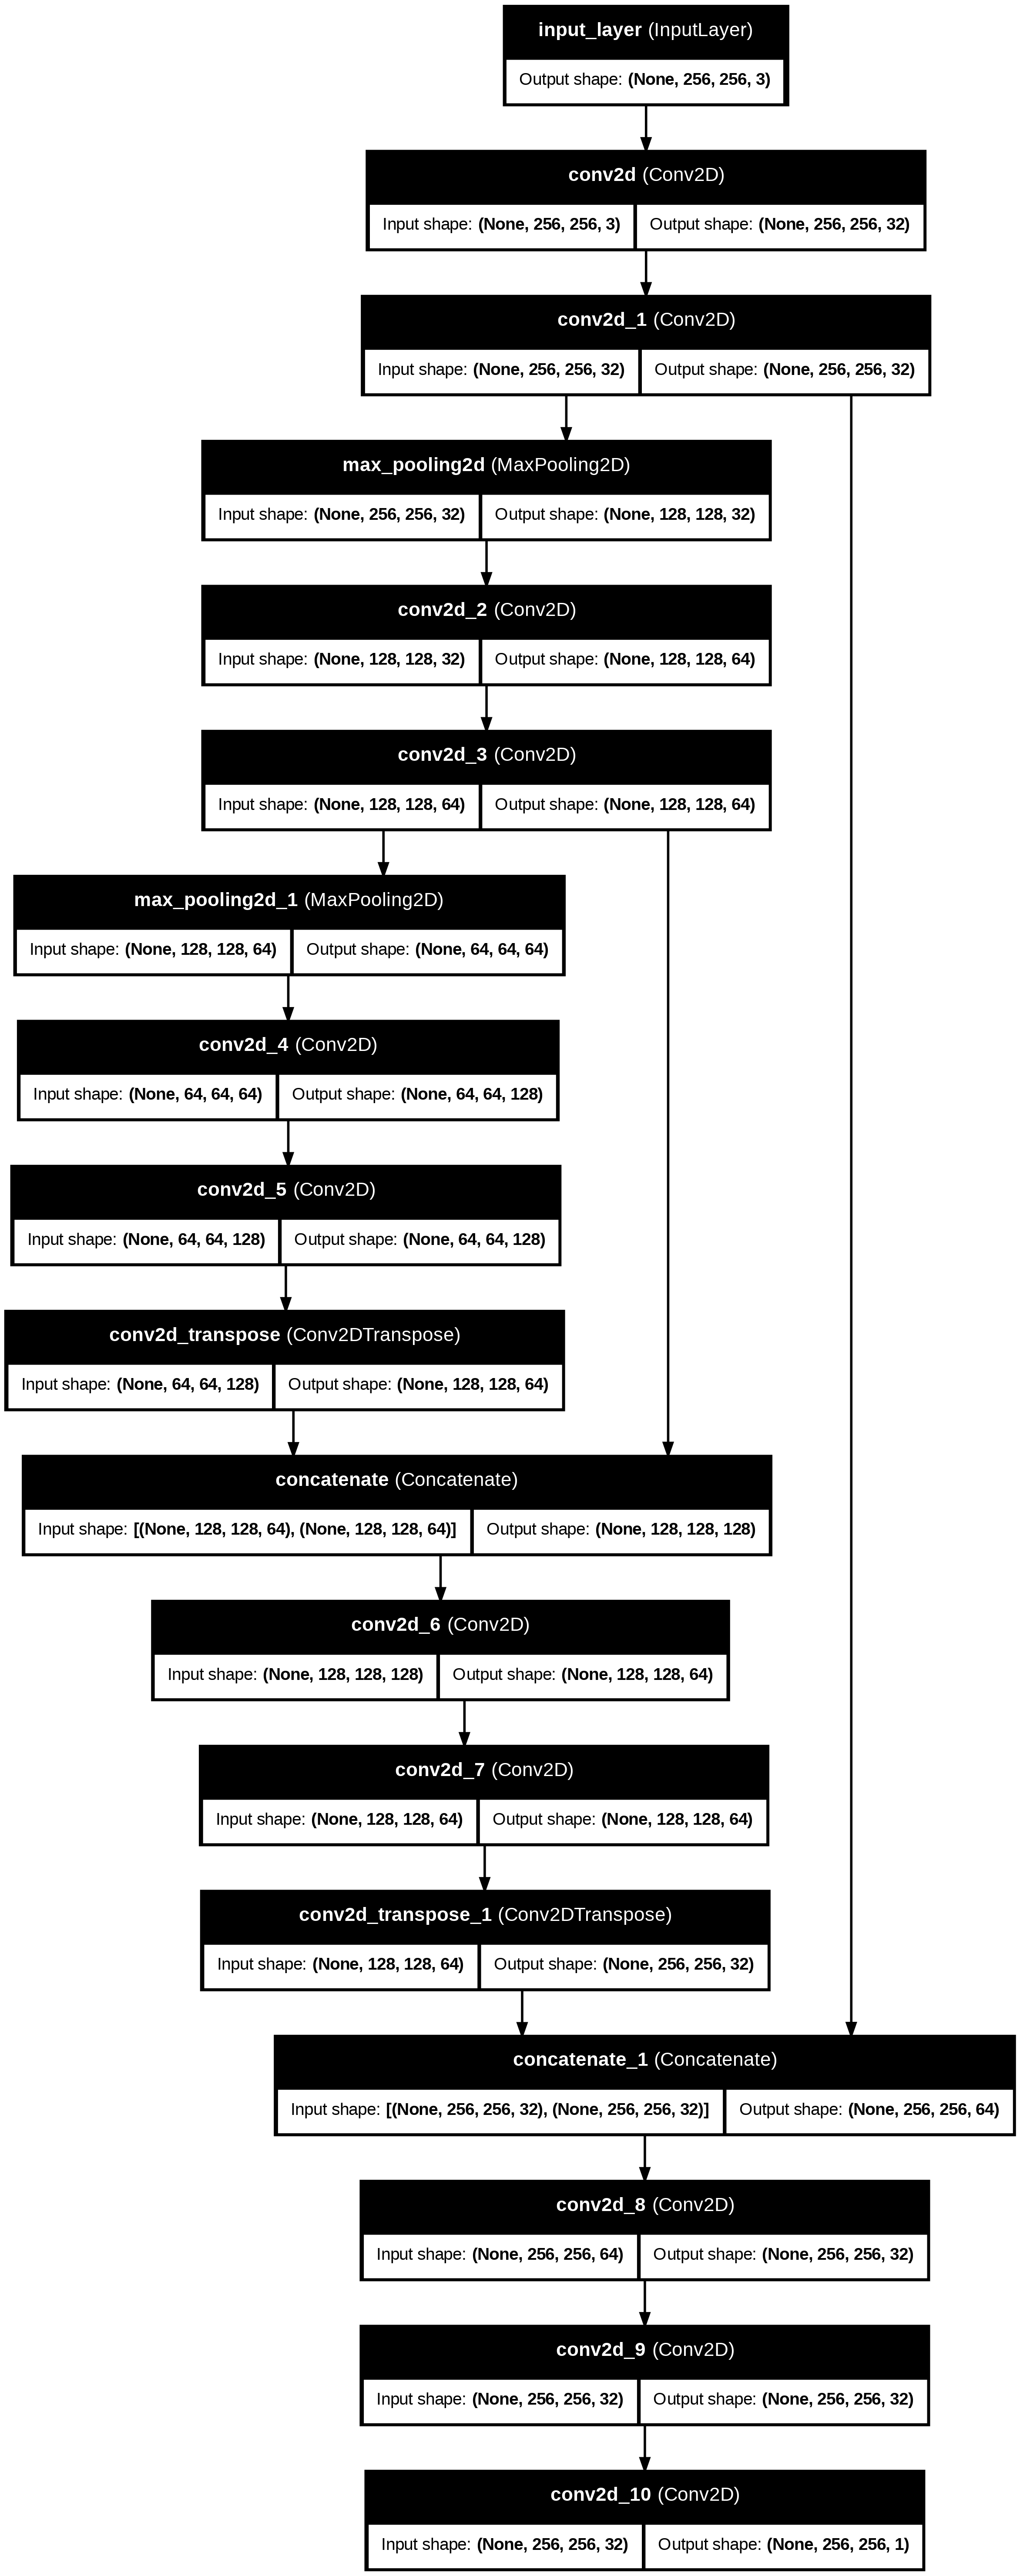

In [14]:
from tensorflow.keras.utils import plot_model

# Save model architecture diagram
plot_model(model, to_file='unet_architecture.png', show_shapes=True, show_layer_names=True)

## 4. Data Loading

In [6]:

## 4. Data Loading ------------------------------------------------
def load_dataset():
    BASE_PATH = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'
    CLASSES = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    
    image_paths = []
    mask_paths = []
    
    for class_name in CLASSES:
        img_dir = os.path.join(BASE_PATH, class_name, 'images')
        mask_dir = os.path.join(BASE_PATH, class_name, 'masks')
        
        for img_file in sorted(os.listdir(img_dir)):
            if img_file.endswith('.png'):
                img_path = os.path.join(img_dir, img_file)
                mask_path = os.path.join(mask_dir, img_file)
                
                if os.path.exists(mask_path):
                    image_paths.append(img_path)
                    mask_paths.append(mask_path)
    
    return image_paths, mask_paths

print("Loading dataset...")
image_paths, mask_paths = load_dataset()
print(f"Found {len(image_paths)} images with masks")

# Split data
train_img, val_img, train_mask, val_mask = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)

# Create generators
train_gen = CovidSegmentationGenerator(train_img, train_mask, batch_size=16)
val_gen = CovidSegmentationGenerator(val_img, val_mask, batch_size=16, shuffle=False)


Loading dataset...
Found 21165 images with masks


## 5. Training 

In [15]:


## 5. Training ----------------------------------------------------
model = build_covid_unet()
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]
)

# Keras 3 compatible checkpoint
callbacks = [
    ModelCheckpoint('best_model.keras',  # Changed to .keras format
                   monitor='val_mean_io_u', 
                   mode='max',
                   save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

print("Starting training...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)



Starting training...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745607733.413047    2301 service.cc:148] XLA service 0x7f6570089050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745607733.416050    2301 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745607734.197143    2301 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1059 ━━━━━━━━━━━━━━━━━━━━ 1:42 97ms/step - accuracy: 0.7262 - loss: 0.6882 - mean_io_u: 0.3788  

I0000 00:00:1745607745.303326    2301 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1059/1059 ━━━━━━━━━━━━━━━━━━━━ 445s 400ms/step - accuracy: 0.8265 - loss: 0.3879 - mean_io_u: 0.2550 - val_accuracy: 0.9394 - val_loss: 0.1600 - val_mean_io_u: 0.2500 - learning_rate: 1.0000e-04
Epoch 2/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 124s 116ms/step - accuracy: 0.9444 - loss: 0.1472 - mean_io_u: 0.2549 - val_accuracy: 0.9601 - val_loss: 0.1082 - val_mean_io_u: 0.2500 - learning_rate: 1.0000e-04
Epoch 3/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 245s 230ms/step - accuracy: 0.9604 - loss: 0.1064 - mean_io_u: 0.2548 - val_accuracy: 0.9690 - val_loss: 0.0835 - val_mean_io_u: 0.2500 - learning_rate: 1.0000e-04
Epoch 4/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 189s 176ms/step - accuracy: 0.9673 - loss: 0.0883 - mean_io_u: 0.2549 - val_accuracy: 0.9727 - val_loss: 0.0738 - val_mean_io_u: 0.2500 - learning_rate: 1.0000e-04
Epoch 5/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 130s 122ms/step - accuracy: 0.9711 - loss: 0.0781 - mean_io_u: 0.2549 - val_accuracy: 0.9741 - val_loss: 0.0698 - val_mean_io_u: 0.2500 - learnin

In [11]:
model = tf.keras.models.load_model("/kaggle/input/tp4_p2/keras/default/1/best_model.keras")

## 📊 Evaluation

I0000 00:00:1745618583.666712    8836 service.cc:148] XLA service 0x795b74003c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745618583.667432    8836 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745618583.791170    8836 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


I0000 00:00:1745618587.639350    8836 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


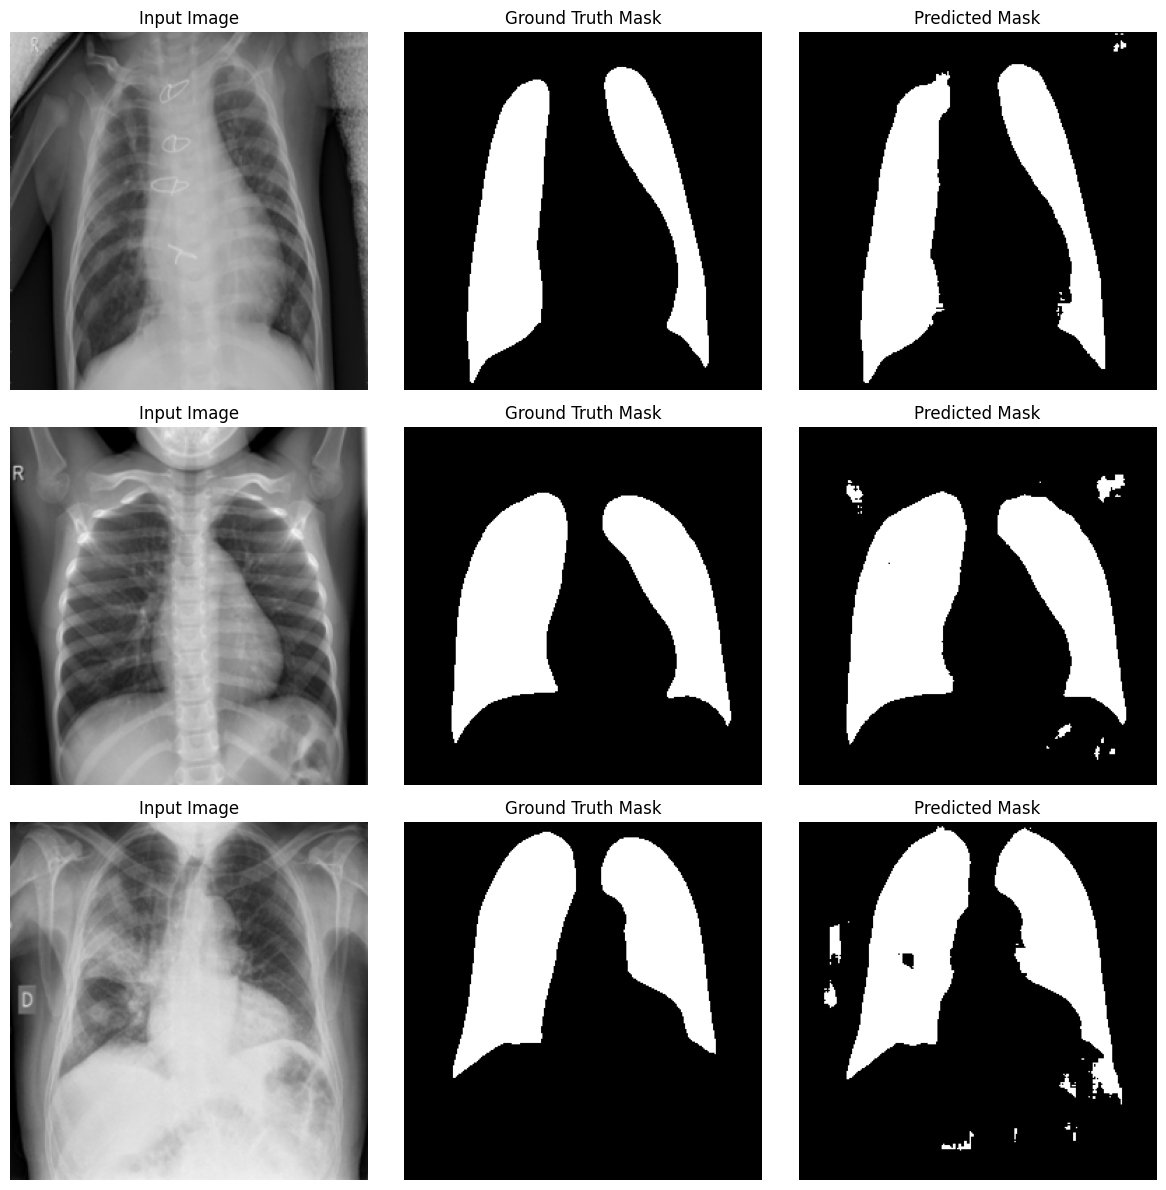

In [ ]:


def plot_predictions(model, val_gen, num_samples=3):
    # Get a batch from validation generator
    X_val, y_val = val_gen[0]  # First batch
    
    # Predict masks
    y_pred = model.predict(X_val)
    
    plt.figure(figsize=(12, num_samples * 4))
    for i in range(num_samples):
        # Original Image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X_val[i])
        plt.title('Input Image')
        plt.axis('off')
        
        # Ground Truth Mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(y_val[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        # Predicted Mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(y_pred[i].squeeze() > 0.5, cmap='gray')  # Threshold at 0.5
        plt.title('Predicted Mask')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('prediction_samples.png')  # Save for report
    plt.show()

# Call the function
plot_predictions(model, val_gen)

In [ ]:


def fast_evaluate(model_path, val_gen, num_samples=3):
    """Optimized evaluation with proper confusion matrix handling"""
    try:
        model = tf.keras.models.load_model(model_path)
        print("✅ Model loaded successfully")
    except Exception as e:
        print(f"❌ Model loading failed: {e}")
        return None
    
    # Initialize metrics
    metrics = {
        'iou': 0, 'dice': 0, 'accuracy': 0,
        'sensitivity': 0, 'specificity': 0,
        'precision': 0, 'recall': 0, 'f1_score': 0,
        'total_pixels': 0
    }
    cm = np.zeros((2, 2))
    sample_data = []
    
    # Evaluation loop
    print("⚡ Running evaluation...")
    for i in tqdm(range(min(50, len(val_gen))), desc="Processing"):
        X, y_true = val_gen[i]
        y_pred = model.predict(X, verbose=0, batch_size=8)
        
        if i == 0:
            sample_data = [(X[j], y_true[j], y_pred[j]) 
                          for j in range(min(num_samples, len(X)))]
        
        y_pred_bin = (y_pred > 0.5).astype(np.uint8)
        batch_metrics, batch_cm = calculate_metrics(y_true, y_pred_bin)
        
        for key in batch_metrics:
            metrics[key] += batch_metrics[key]
        cm += batch_cm
        
        del X, y_true, y_pred, y_pred_bin
        if i % 10 == 0:
            gc.collect()
    
    # Final metrics
    metrics.update({
        'mean_iou': metrics['iou'] / metrics['total_pixels'],
        'mean_dice': metrics['dice'] / metrics['total_pixels'],
        'mean_accuracy': metrics['accuracy'] / metrics['total_pixels'],
        'confusion_matrix': cm.astype(int)  # Ensure integer type for confusion matrix
    })
    
    # Calculate classification metrics
    tn, fp, fn, tp = metrics['confusion_matrix'].ravel()
    eps = 1e-7
    metrics.update({
        'sensitivity': tp / (tp + fn + eps),
        'specificity': tn / (tn + fp + eps),
        'precision': tp / (tp + fp + eps),
        'recall': tp / (tp + fn + eps),
        'f1_score': 2 * (metrics['precision'] * metrics['recall']) / 
                   (metrics['precision'] + metrics['recall'] + eps)
    })
    
    # Generate visualizations
    if sample_data:
        generate_visualizations(sample_data, metrics['confusion_matrix'], metrics)
    
    return metrics

def calculate_metrics(y_true, y_pred):
    """Calculate metrics with proper float handling"""
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten(), labels=[0, 1])
    intersection = np.sum(y_true * y_pred)
    total_pixels = np.prod(y_true.shape)
    
    return {
        'iou': intersection,
        'dice': 2 * intersection,
        'accuracy': np.sum(y_true == y_pred),
        'total_pixels': total_pixels
    }, cm

def generate_visualizations(samples, cm, metrics):
    """Generate visualizations with proper formatting"""
    plt.figure(figsize=(18, 12))
    
    # 1. Confusion Matrix with automatic formatting
    plt.subplot(2, 2, 1)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',  # 'g' for general number formatting
                xticklabels=['Background', 'Lung'],
                yticklabels=['Background', 'Lung'])
    plt.title('Confusion Matrix\n(True vs Predicted pixels)', pad=20)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Add metrics
    plt.text(0.5, -0.3, 
             f"Accuracy: {metrics['mean_accuracy']:.4f}\n"
             f"Sensitivity: {metrics['sensitivity']:.4f}\n"
             f"Specificity: {metrics['specificity']:.4f}\n"
             f"Precision: {metrics['precision']:.4f}",
             ha='center', va='center', transform=plt.gca().transAxes)
    
    # 2. Sample predictions
    for i, (img, mask, pred) in enumerate(samples):
        plt.subplot(2, 2, 2 + i)
        if img.shape[-1] == 1:  # Grayscale
            disp_img = np.stack([img.squeeze()]*3, axis=-1)
        else:  # RGB
            disp_img = img
            
        true_mask = np.stack([mask.squeeze()]*3, axis=-1)
        pred_mask = np.stack([(pred.squeeze() > 0.5).astype(np.uint8)]*3, axis=-1)
        
        plt.imshow(np.hstack([disp_img, true_mask, pred_mask]))
        plt.title(f"Sample {i+1}: Input | True | Predicted\n(IoU: {metrics['mean_iou']:.3f})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('evaluation_results.png', bbox_inches='tight', dpi=120)
    plt.close()
    
    # Additional normalized confusion matrix
    plt.figure(figsize=(8, 6))
    normalized_cm = cm / cm.sum()
    sns.heatmap(normalized_cm, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=['Background', 'Lung'],
                yticklabels=['Background', 'Lung'])
    plt.title('Normalized Confusion Matrix (% of total pixels)')
    plt.savefig('confusion_matrix_normalized.png', bbox_inches='tight', dpi=120)
    plt.close()

# Usage
model_path = "/kaggle/input/tp4_p2/keras/default/1/best_model.keras"
metrics = fast_evaluate(model_path, val_gen)

if metrics:
    print("\n📊 Evaluation Results:")
    print(f"IoU: {metrics['mean_iou']:.4f}")
    print(f"Dice: {metrics['mean_dice']:.4f}")
    print(f"Accuracy: {metrics['mean_accuracy']:.4f}")
    print(f"Sensitivity/Recall: {metrics['sensitivity']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print("\nConfusion Matrix (Counts):")
    print(metrics['confusion_matrix'])
    print("\nVisualizations saved to:")
    print("- evaluation_results.png (main report)")
    print("- confusion_matrix_normalized.png (percentage view)")

✅ Model loaded successfully
⚡ Running evaluation...


Processing: 100%|██████████| 50/50 [00:18<00:00,  2.63it/s]



📊 Evaluation Results:
IoU: 0.2277
Dice: 0.4554
Accuracy: 0.9828
Sensitivity/Recall: 0.9741
Specificity: 0.9855
Precision: 0.9535
F1 Score: 0.0000

Confusion Matrix (Counts):
[[39590063   582701]
 [  317851 11938185]]

Visualizations saved to:
- evaluation_results.png (main report)
- confusion_matrix_normalized.png (percentage view)
